In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import skew, norm, probplot, boxcox, f_oneway

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
# Fix data types
# df['Pregnancies'] = df['colname'].astype('category')
# df['colname'] = df['colname'].astype('float')
# df['colname'] = df['colname'].astype('int')

df['Outcome'] = df['Outcome'].astype('category')

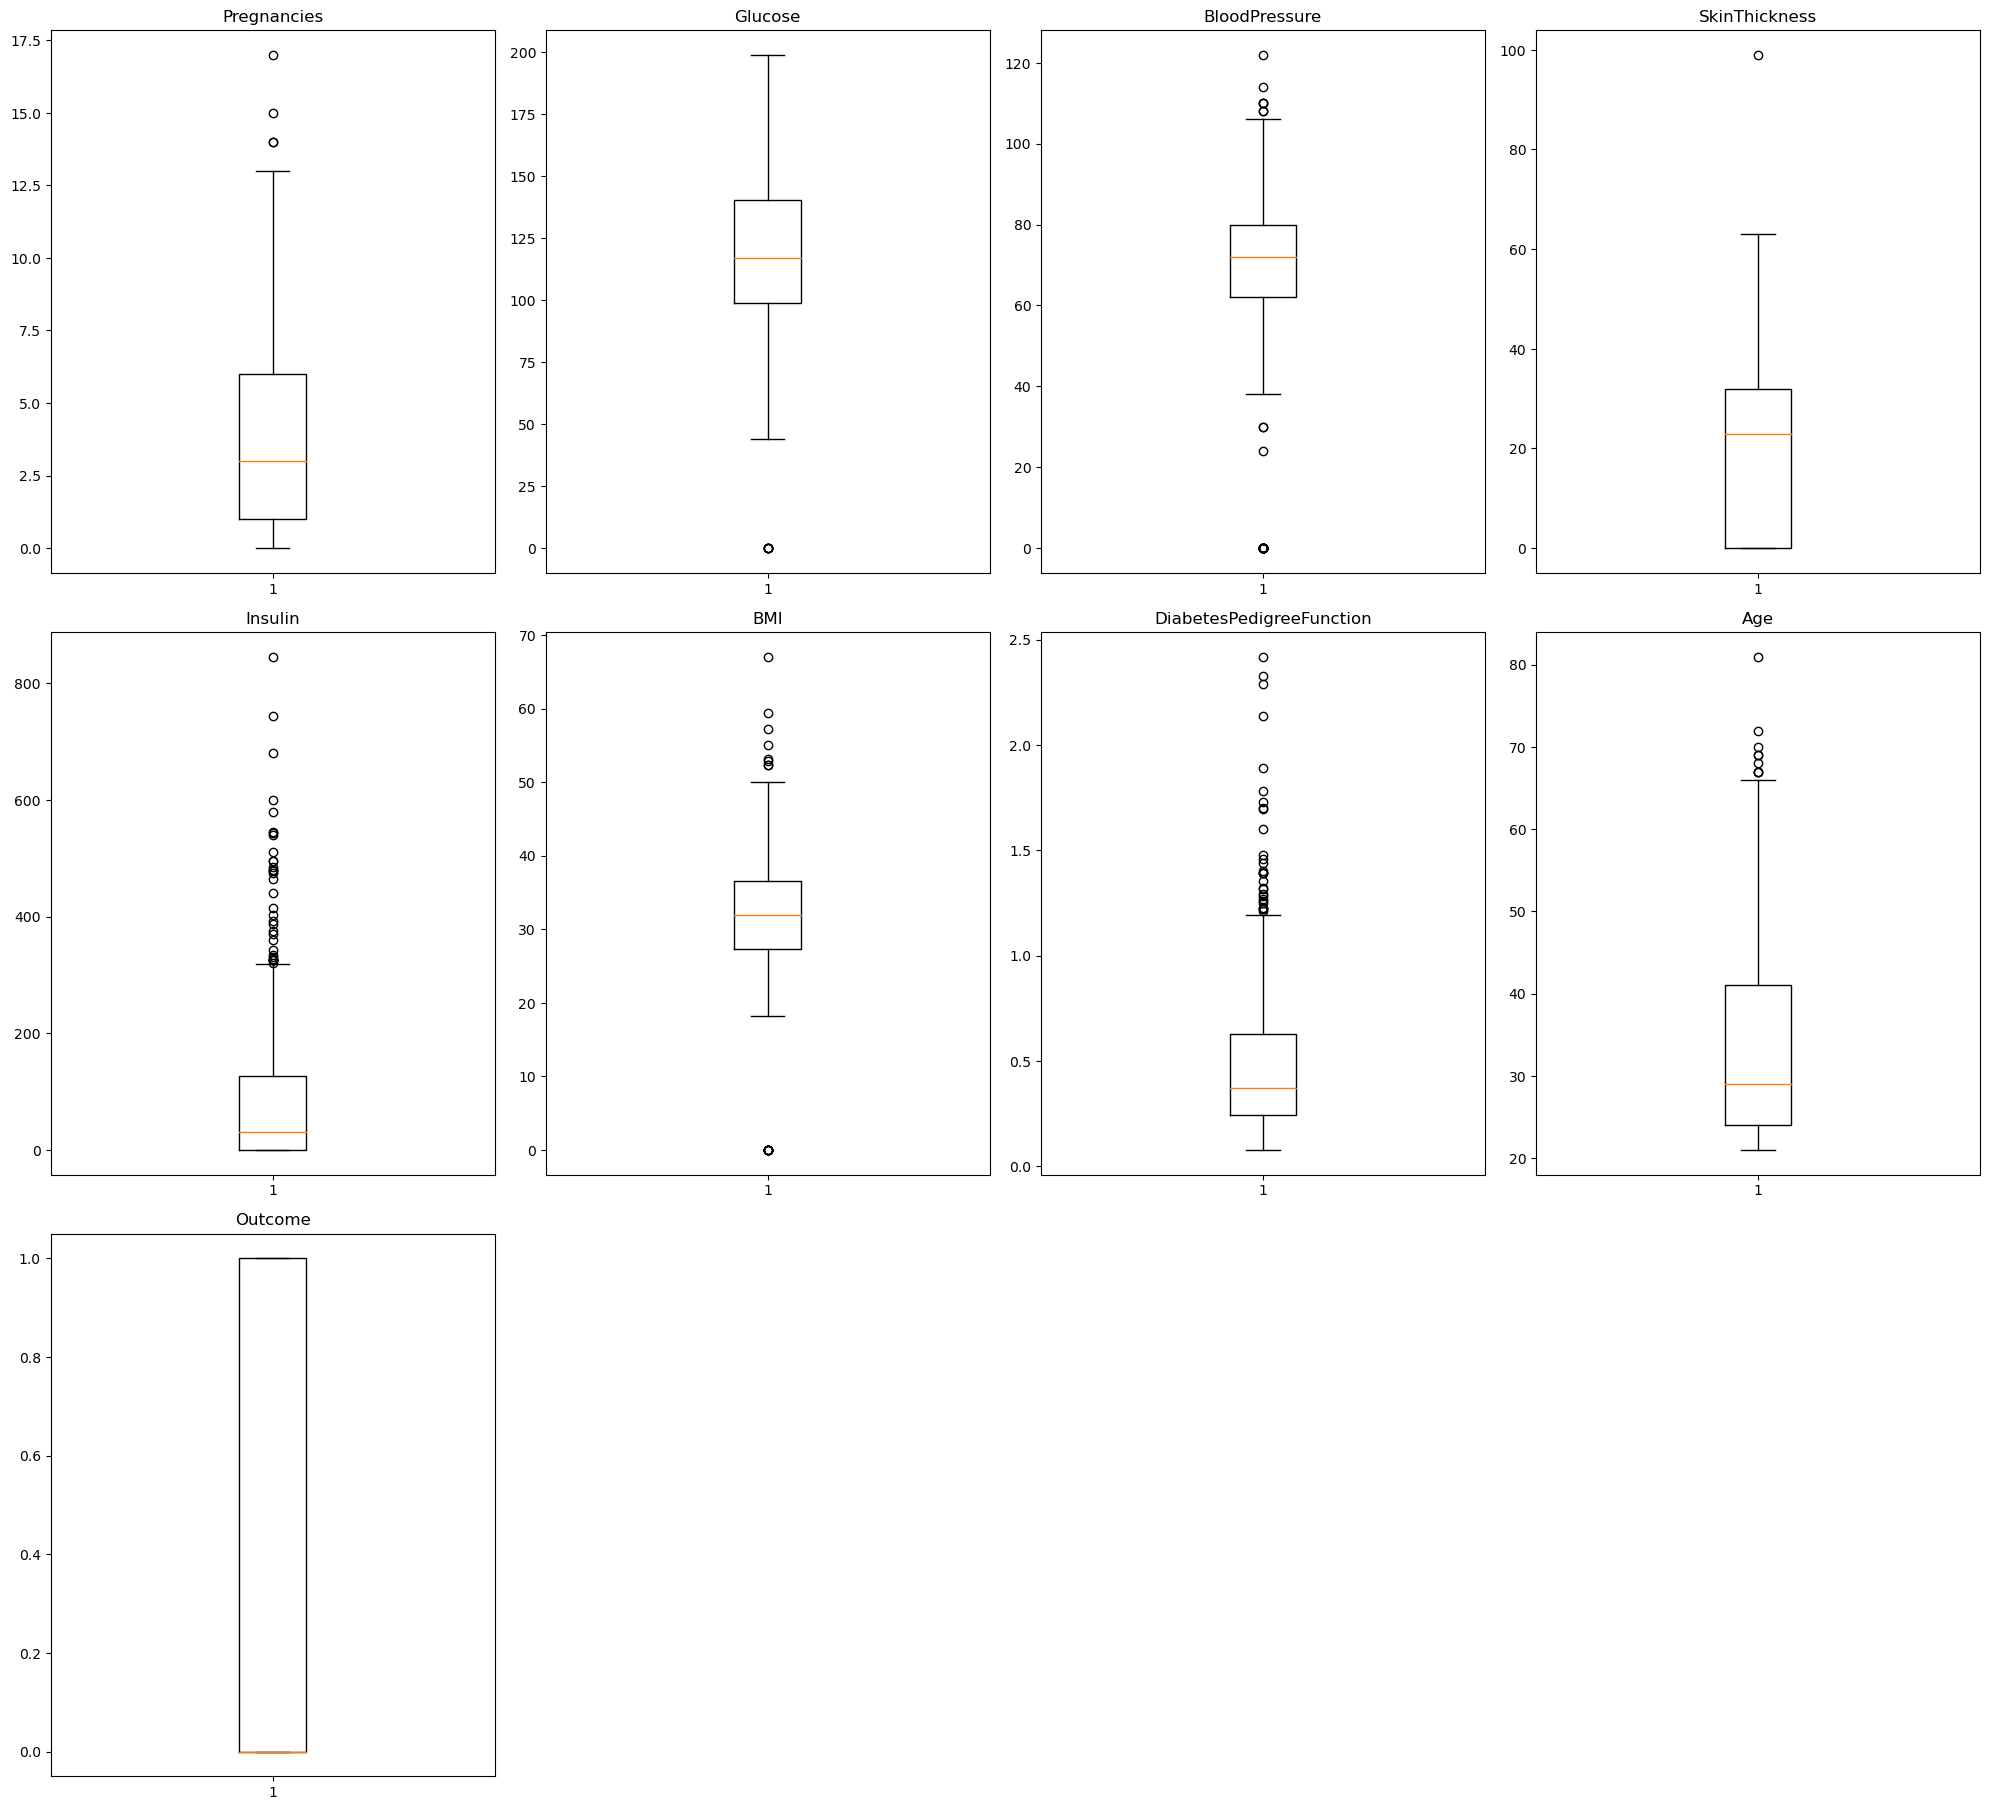

In [5]:
## RECALL...
# Outlier detection using boxplots

plt.figure(figsize=(20,30))

for i, variable in enumerate(df):
                     plt.subplot(5,4,i+1)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)
                    
plt.show()

In [7]:
# Use flooring and capping method
def treat_outliers(df,col):
    Q1=df[col].quantile(0.25) 
    Q3=df[col].quantile(0.75) 
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)                                                            
    return df

def treat_outliers_all(df, col_list):
    for c in col_list:
        df = treat_outliers(df,c)
    return df

In [8]:
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
df = treat_outliers_all(df,numerical_col)

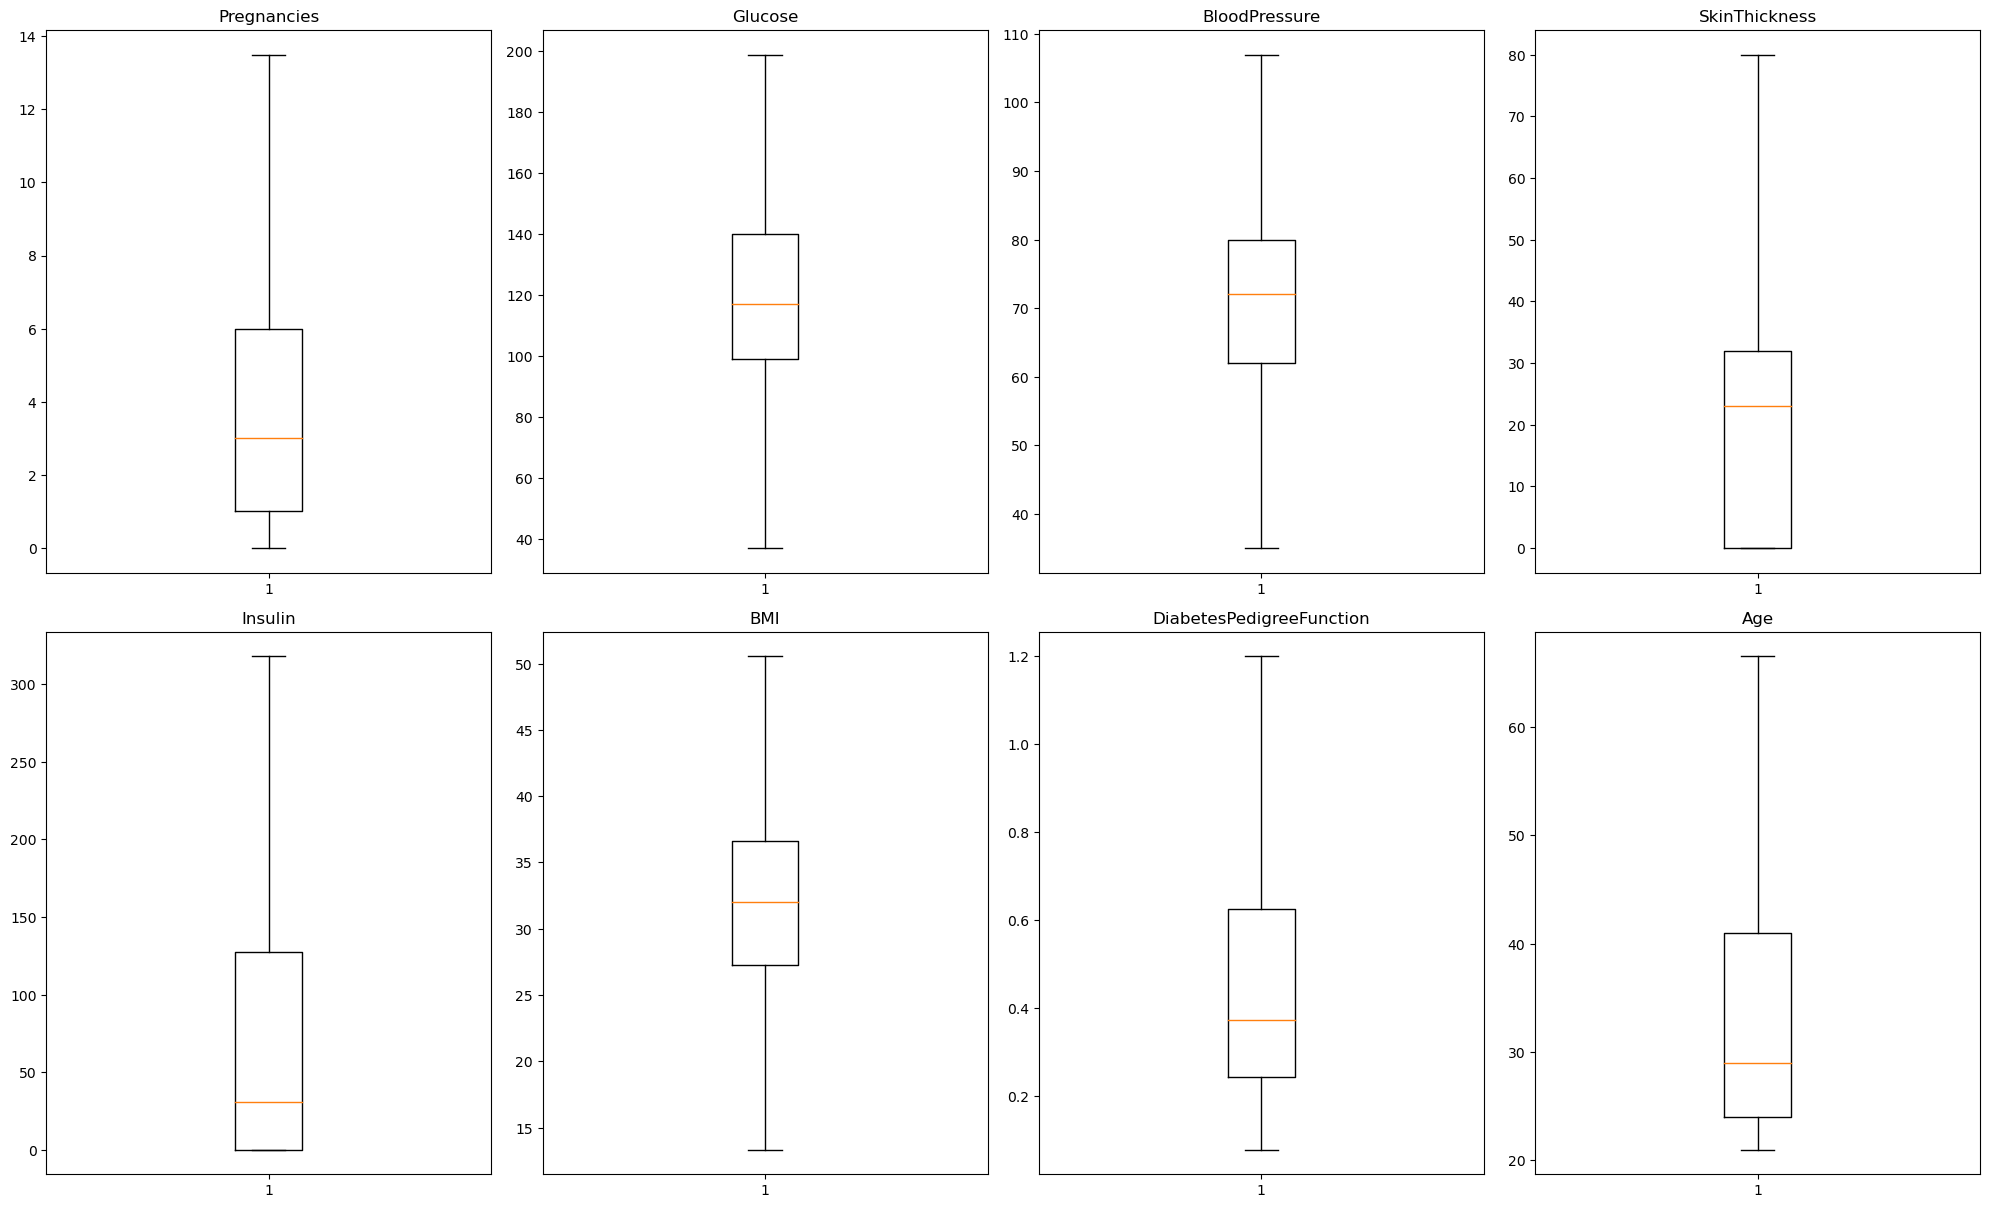

In [9]:
plt.figure(figsize=(20,30))

for i, variable in enumerate(numerical_col):
                     plt.subplot(5,4,i+1)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

In [10]:
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import stats, norm, skew
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
from sklearn import metrics
from sklearn import datasets

In [11]:
# Make copy of data
data=df.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    float64 
 1   Glucose                   768 non-null    float64 
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    float64 
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(6), int64(2)
memory usage: 49.0 KB


In [12]:
X = data.drop('Outcome',axis=1)    # Features
y = data['Outcome'].astype('int64') # Labels (Target or Outcome Variable)
# converting target to integers - since some functions might not work with bool type

In [13]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(537, 8) (231, 8)


In [14]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini',class_weight={0:0.15,1:0.85},random_state=1)

# 2 commonly used splitting criteria are Gini impurity and information gain (entropy)
# Gini: measures the probability of misclassifying a randomly chosen element if it were randomly labeled
    # Would goal be to minimize or maximize the Gini impurity when making splits???
        # MINIMIZE
    
    
# Information Gain (Entropy): entropy measures impurity or uncertainty, while information gain quantifies reduction in entropy
    # Which do we want to minimize? Maximize?
        # MINIMIZE Entropy
        # MAXIMIZE Information Gain

In [15]:
model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 0.15, 1: 0.85}, random_state=1)

In [16]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

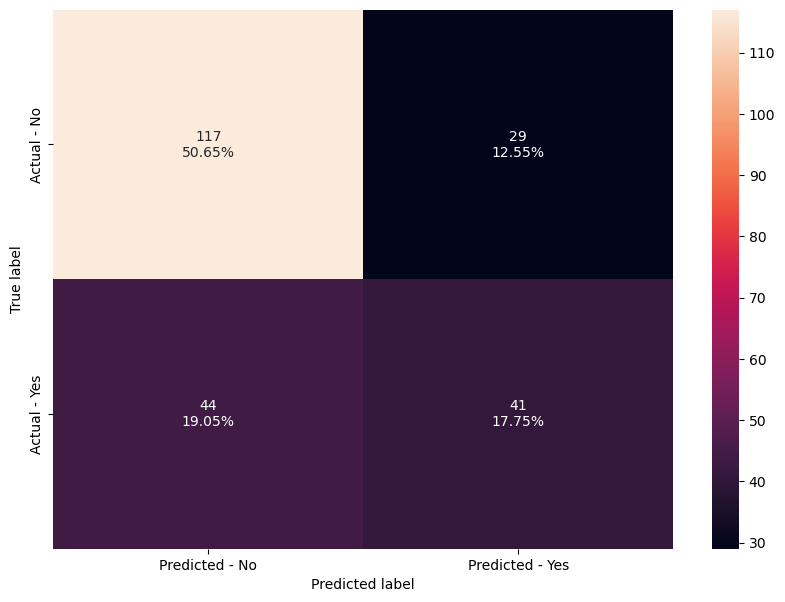

In [17]:
make_confusion_matrix(model,y_test)


In [18]:
y_train.value_counts(1)


0    0.659218
1    0.340782
Name: Outcome, dtype: float64

In [19]:
##  Function to calculate recall score
def get_recall_score(model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,pred_test))

In [20]:
get_recall_score(model)


Recall on training set :  1.0
Recall on test set :  0.4823529411764706


In [21]:
column_names = list(data.columns)
column_names.remove('Outcome')  # As this is the DV                
feature_names = column_names
print(feature_names)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


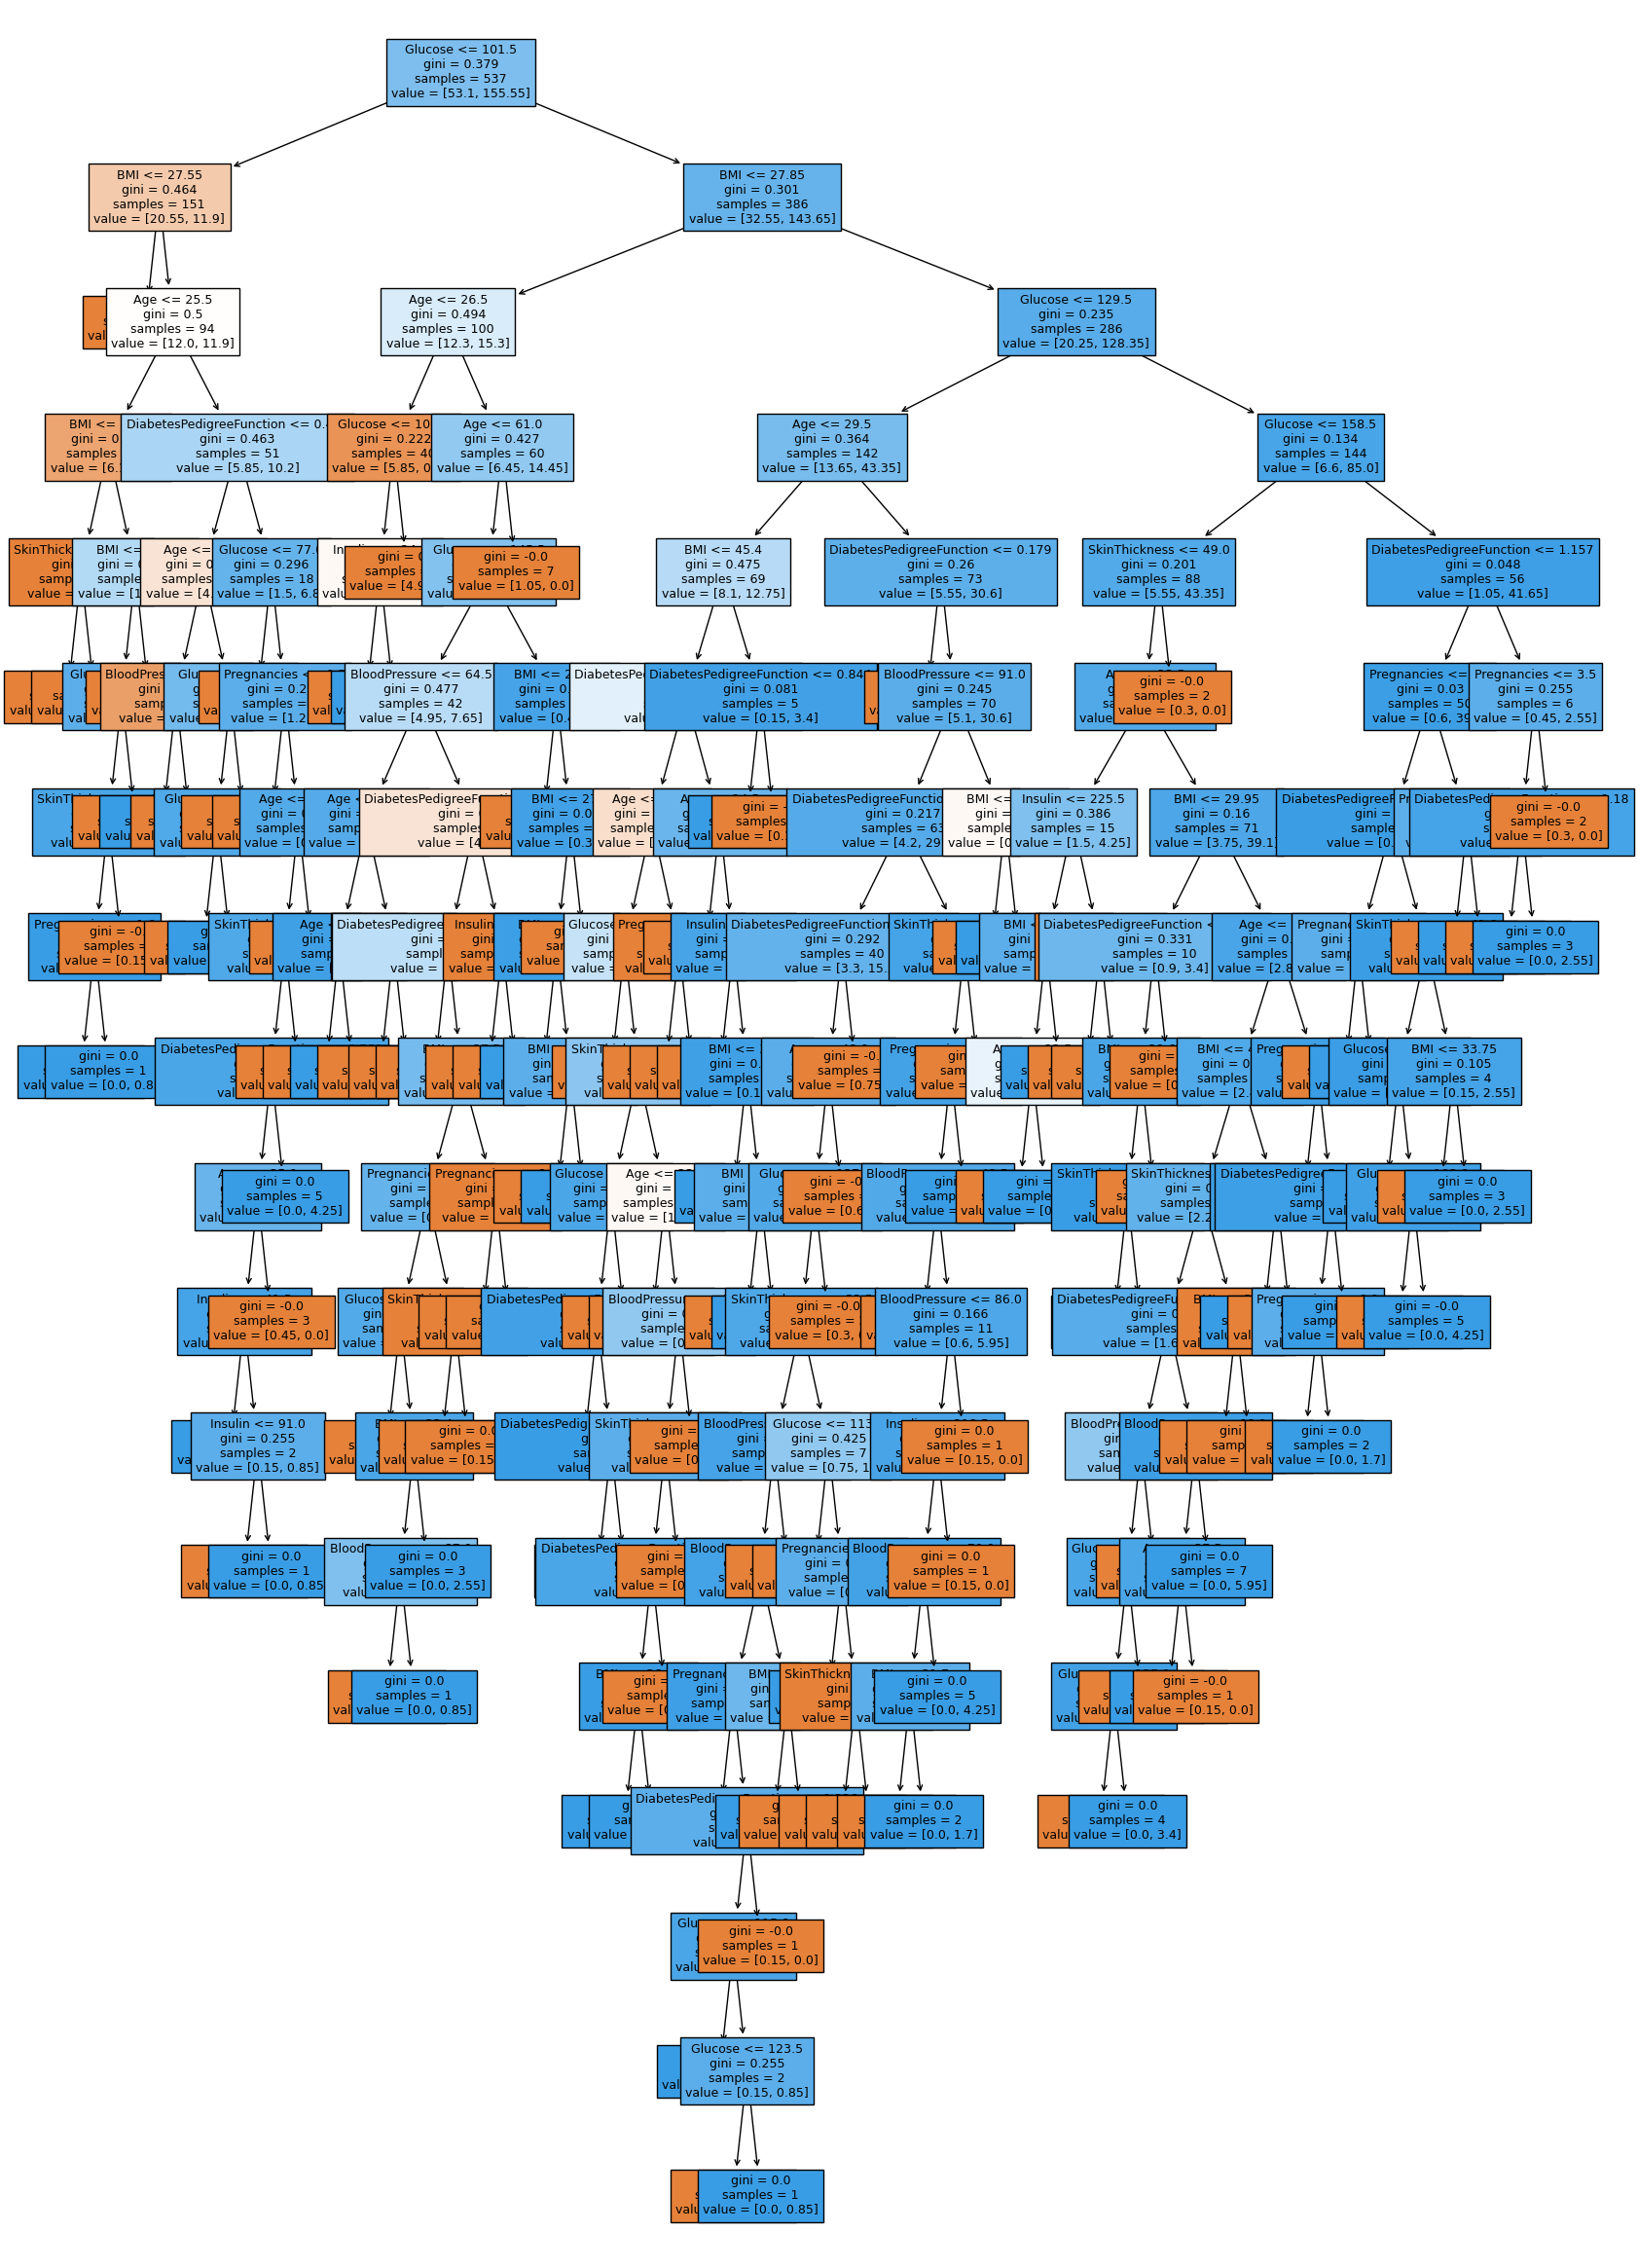

In [22]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

plt.figure(figsize=(20,30))
out = tree.plot_tree(model,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None,)
# Code below will add arrows to the decision tree split if they are missing
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [23]:
print(tree.export_text(model,feature_names=feature_names,show_weights=True))


|--- Glucose <= 101.50
|   |--- BMI <= 27.55
|   |   |--- weights: [8.55, 0.00] class: 0
|   |--- BMI >  27.55
|   |   |--- Age <= 25.50
|   |   |   |--- BMI <= 37.30
|   |   |   |   |--- SkinThickness <= 5.00
|   |   |   |   |   |--- weights: [0.45, 0.00] class: 0
|   |   |   |   |--- SkinThickness >  5.00
|   |   |   |   |   |--- weights: [4.65, 0.00] class: 0
|   |   |   |--- BMI >  37.30
|   |   |   |   |--- BMI <= 38.30
|   |   |   |   |   |--- Glucose <= 97.50
|   |   |   |   |   |   |--- SkinThickness <= 33.00
|   |   |   |   |   |   |   |--- Pregnancies <= 1.00
|   |   |   |   |   |   |   |   |--- weights: [0.00, 0.85] class: 1
|   |   |   |   |   |   |   |--- Pregnancies >  1.00
|   |   |   |   |   |   |   |   |--- weights: [0.00, 0.85] class: 1
|   |   |   |   |   |   |--- SkinThickness >  33.00
|   |   |   |   |   |   |   |--- weights: [0.15, 0.00] class: 0
|   |   |   |   |   |--- Glucose >  97.50
|   |   |   |   |   |   |--- weights: [0.15, 0.00] class: 0
|   |   |   |   |

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,5))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
